# Predictive Modeling of Semiconductor Manufacturing Process Using Machine Learning

The aim of this project is to develop a predictive model using machine learning techniques to identify the key factors contributing to yield excursions in the semiconductor manufacturing process. The model will be trained and tested on the SECOM dataset from the UCI Machine Learning Repository.

The SECOM dataset represents a complex real-world problem where process yield (pass/fail) is influenced by many factors or features. The challenge is to model these features effectively to predict the yield outcome, which can help in improving the overall manufacturing process.

Data received from : https://www.kaggle.com/datasets/paresh2047/uci-semcom/data

# Importing Required modules

In [1]:
#import data libraries
import pandas as pd
import numpy as np
#import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Read in and quick look at the data

In [2]:
# Read the cvs and convert into pandas Dataframe
secom_df = pd.read_csv('uci-secom.csv', sep=',')
pd.set_option('display.max_rows', 1000)
# Check the shape and content
print(secom_df.shape)
display(secom_df.head())

print(secom_df.dtypes.head())


(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


Time     object
0       float64
1       float64
2       float64
3       float64
dtype: object


In [3]:
missingValues = secom_df.isnull().sum().sum()
print(missingValues)
# display(secom_df.isnull().sum())

41951


Looking at the dataset it has 1567 rows and 592 columns. It contains 41951 missing values. In order to handle missing values
I will replace them with 0. The most common way of handling missing values are assigning mean, median or most frequent. In the context of semiconductor manufacturing missing value means there is no signal recorded thus changing values to 0 rather then mean will give us better result.

In [4]:
from sklearn.impute import SimpleImputer
# define imputor model  to fill missing values with 0
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
# Fit the mode to our own dataframe
secom_df = pd.DataFrame(imputer.fit_transform(secom_df), columns=secom_df.columns).astype(secom_df.dtypes.to_dict())
# Check if there are missing values
print(secom_df.isnull().sum().sum())

0


The goal of this project is to predict if the product will be successfull or not based on the test features.

# Exploratory Data Analysis

### Data munging and cleaning

First step is to divide the data to features and target.

In [5]:
# Create target dataframe which is y values
y = secom_df['Pass/Fail']
display(y.head())
# Create features df which is X values
X = secom_df.iloc[:,0:591]
# print(X.dtypes)
#dropping the time column
X.drop("Time",axis=1,inplace=True)
display(X.head())
# print(X.dtypes)

0   -1
1   -1
2    1
3   -1
4   -1
Name: Pass/Fail, dtype: int64

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0000,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.0000,0.0000,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


Time column represents the time of the observation. Time could be helpfull if we are analyzing how the testing changes through time but for predicting pass/fail Time column is not needed

We could look into some statistics of the data first.

In [6]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3002.910638,2484.700932,2180.887035,1383.901023,4.159516,99.106573,100.209538,0.121122,1.460995,-0.000840,...,0.002128,38.623767,0.499777,0.015308,0.003844,3.065869,0.021445,0.016464,0.005280,99.606461
std,200.204648,184.815753,209.206773,458.937272,56.104457,9.412812,11.363940,0.012831,0.090461,0.015107,...,0.003284,72.871466,0.013084,0.017179,0.003721,3.577730,0.012366,0.008815,0.002869,93.895701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016900,0.000000,0.000000,0.000000
25%,2965.670000,2451.515000,2180.700000,1080.116050,1.011000,100.000000,97.762200,0.121100,1.410950,-0.010800,...,0.000000,0.000000,0.497900,0.011600,0.003100,2.306200,0.013400,0.010600,0.003300,44.368600
50%,3010.920000,2498.910000,2200.955600,1283.436800,1.310100,100.000000,101.492200,0.122400,1.461500,-0.001300,...,0.000000,0.000000,0.500200,0.013800,0.003600,2.757600,0.020500,0.014800,0.004600,71.778000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,100.000000,104.530000,0.123800,1.516850,0.008400,...,0.003900,57.449750,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.000000,129.252200,0.128600,1.656400,0.074900,...,0.028600,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


There are huge variance between columns. To fix this we need to standardize the data. Standardization is important so that the features are on the same scale and have similar distributions, preventing any one feature from dominating due to scale differences.

In [7]:
from sklearn.preprocessing import StandardScaler

sdscaler = StandardScaler()
X_standardized = sdscaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

display(X_standardized.describe().round(3))
X = X_standardized

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
count,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,...,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000,1567.000
mean,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-15.004,-13.448,-10.428,-3.016,-0.074,-10.532,-8.821,-9.443,-16.156,-3.480,...,-0.648,-0.530,-38.211,-0.891,-1.034,-0.857,-3.102,-1.868,-1.841,-1.061
25%,-0.186,-0.180,-0.001,-0.662,-0.056,0.095,-0.215,-0.002,-0.553,-0.660,...,-0.648,-0.530,-0.144,-0.216,-0.200,-0.212,-0.651,-0.666,-0.690,-0.588
50%,0.040,0.077,0.096,-0.219,-0.051,0.095,0.113,0.100,0.006,-0.030,...,-0.648,-0.530,0.032,-0.088,-0.066,-0.086,-0.076,-0.189,-0.237,-0.296
75%,0.268,0.293,0.178,0.450,-0.047,0.095,0.380,0.209,0.618,0.612,...,0.540,0.258,0.197,0.069,0.069,0.064,0.498,0.435,0.390,0.161
max,1.766,1.958,0.643,5.081,19.798,0.095,2.557,0.583,2.161,5.015,...,8.064,9.591,0.766,26.861,27.063,26.908,6.581,7.199,8.130,6.794


In [8]:
secom_df[X.columns]

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0000,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.0000,0.0000,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,0.0000,0.0000,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,0.0000,0.0000,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


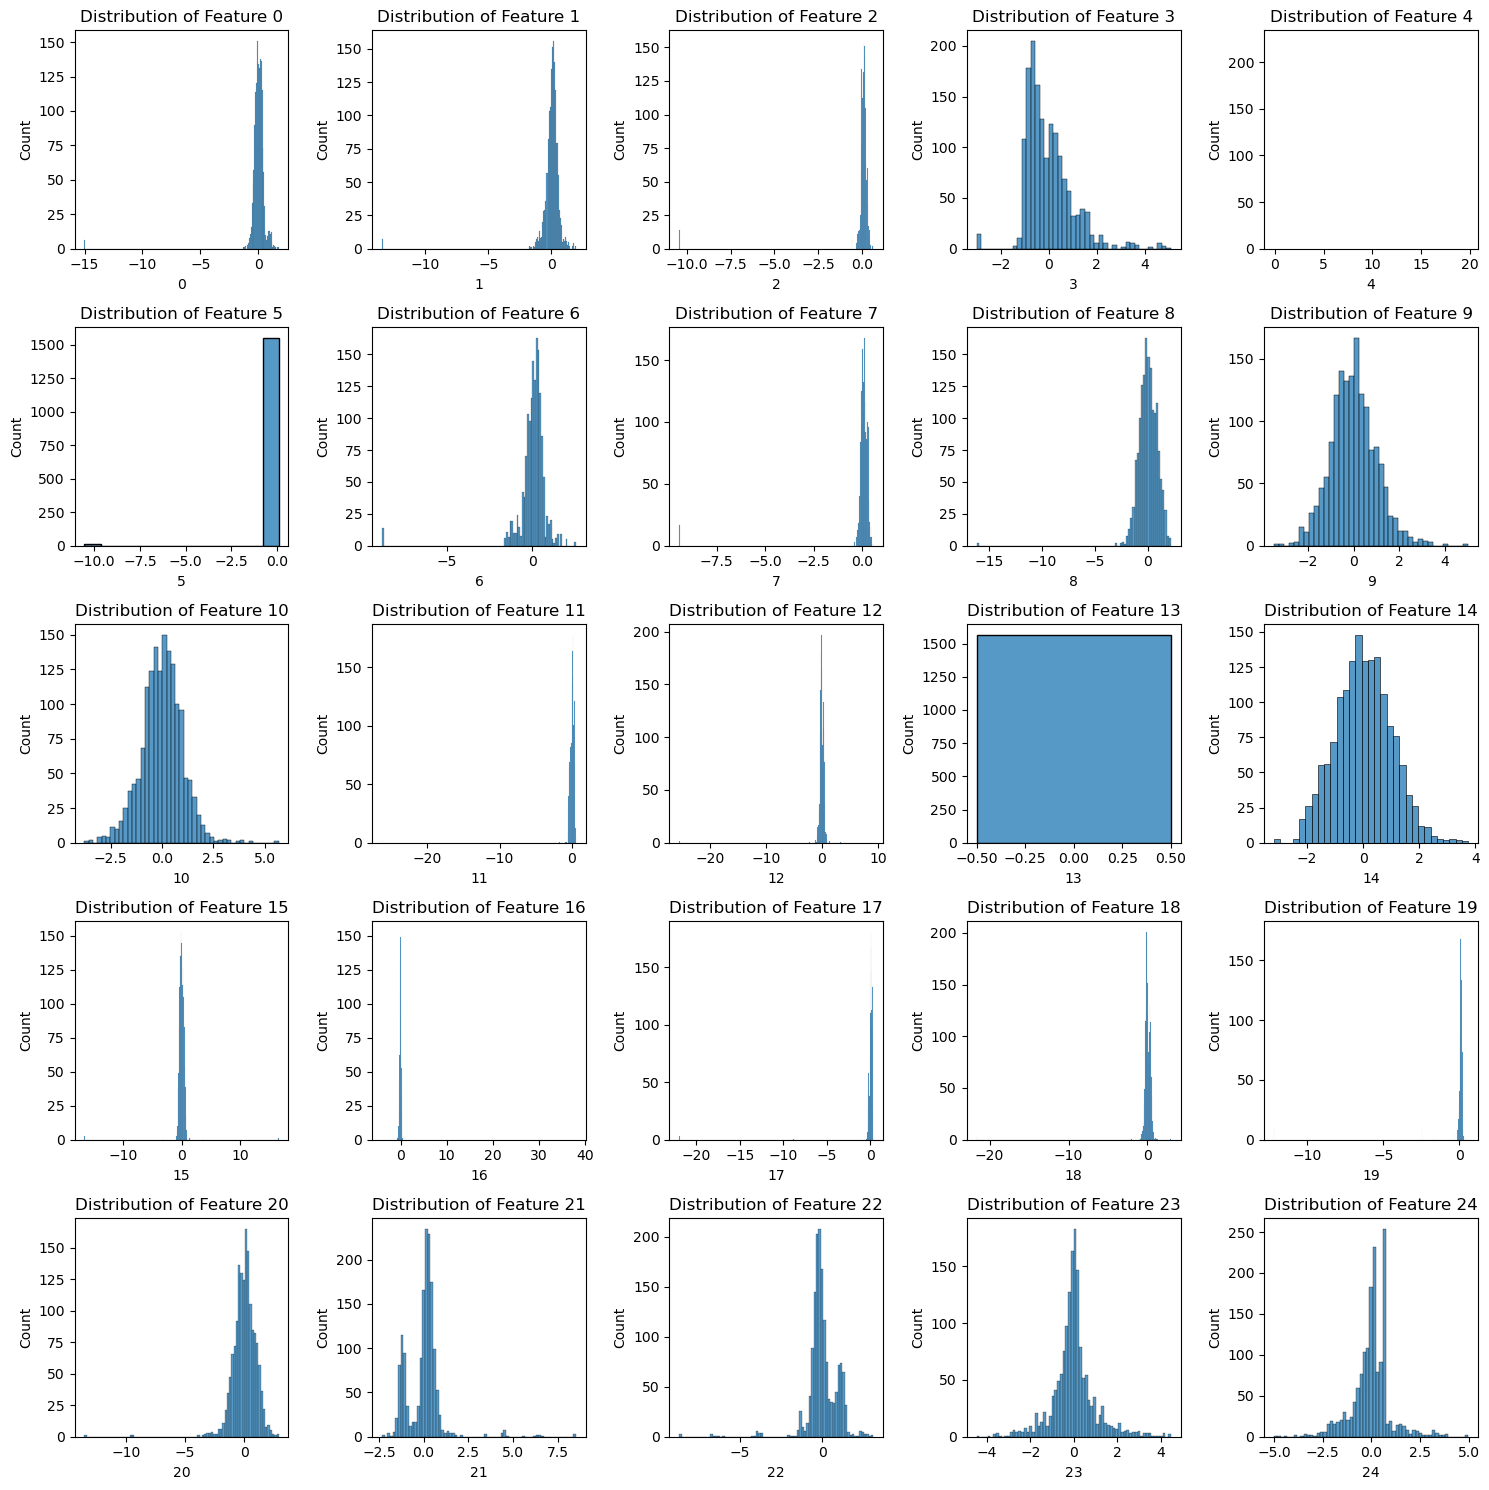

In [9]:


fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# turns 2D array to 1d array
axs = axs.flatten()

# Iterate over each column of the DataFrame and each subplot axis at the same time
# using zip

for ax, column in zip(axs, X.columns):
    sns.histplot(X[column], ax=ax)
    ax.set_title(f'Distribution of Feature {column}')

plt.tight_layout()
plt.show()



The histograms of the subset of the features in our dataset are plotted above. Most of these histograms exhibit a bell shape, which is characteristic of a normal distribution. So we can assume that our dataset have gaussian distribution

Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64


Text(0.5, 1.0, 'Histogram of Pass/Fail')

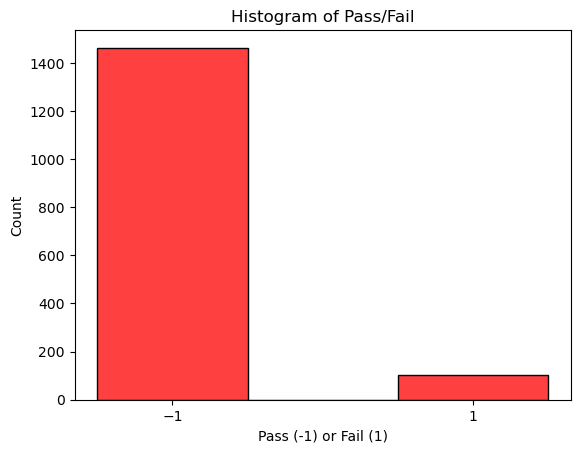

In [10]:
print(y.value_counts())

plt.figure()
sns.histplot(y,color='red', bins=[-1.5, -0.5, 0.5, 1.5])
plt.xticks([-1,1])
plt.xlabel('Pass (-1) or Fail (1)')
plt.title('Histogram of Pass/Fail')

The graph shows the our target variable data is skewd. There are more pass in the dataset than fails. Many techniques like over/under sampling or synthetic sampling could be used to solve the imbalance issues however I will not use those techniques on this project.

# Building and Testing Model

### Building a Naive Bayes Model

First we split the data into training and test data. I set the random state for code reproducilbility

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
# print(X_train.shape)
# print(X_test.shape)

#### Training the model

In [12]:
# Model creation
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

#### Predict

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = gnb.predict(X_test)

print("Accuracy on test set:",accuracy_score(y_test, y_pred))

Accuracy on test set: 0.15286624203821655


              precision    recall  f1-score   support

          -1       0.93      0.13      0.22       301
           1       0.04      0.77      0.07        13

    accuracy                           0.15       314
   macro avg       0.48      0.45      0.15       314
weighted avg       0.89      0.15      0.22       314



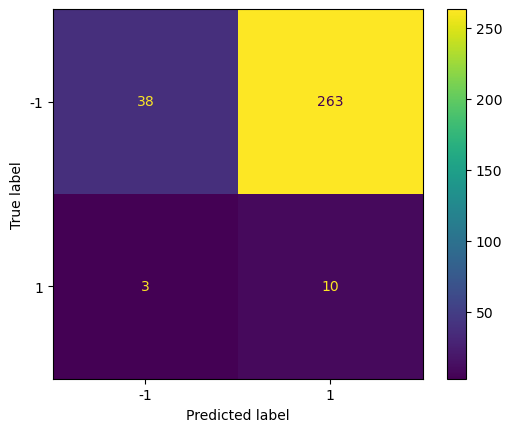

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

print(classification_report(y_test, y_pred))

The model currently has an accuracy of 15.28%, meaning it correctly predicts the outcome only about 15% of the time. The F1 score, which balances precision and recall, is also low at 22%. This suggests the model often incorrectly predicts a pass when the semiconductor actually fails the test—a serious issue known as a high false positive rate.

One possible reason for these results is that the Naive Bayes model we’re using assumes features are independent, but some of our features are highly correlated. This violates the model’s assumptions and could be hurting its performance.

 Thus I wanted to look at our features and remove the features that are highly correlated to eachother. I will remove the features that are highly correlated and train a new model and compare the results.

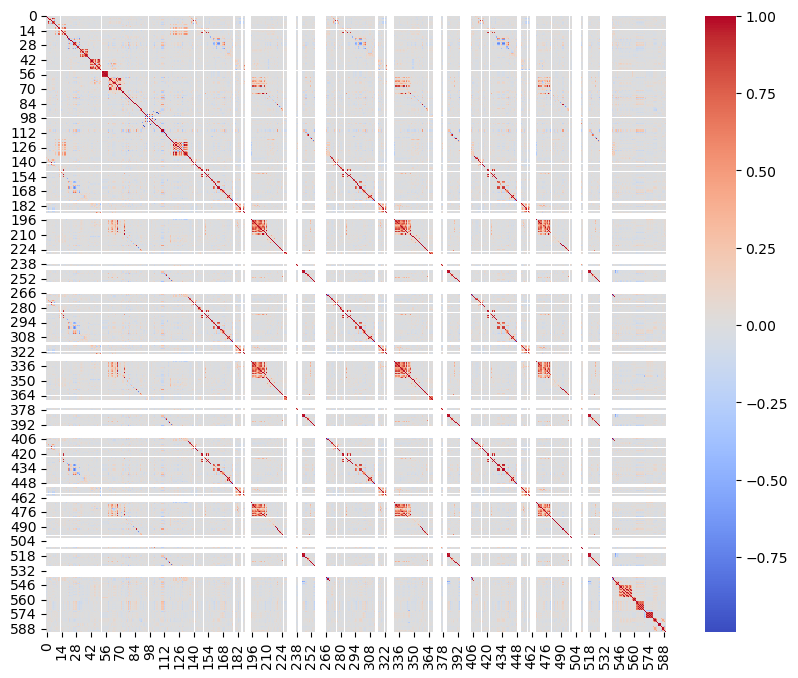

In [15]:
# Calculate the correlation matrix
corr_matrix = secom_df.iloc[:,1:].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [16]:
# Find correlations greater than 0.8 or less than -0.8
highly_correlated_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            # colname_i = corr_matrix.columns[i]
            # colname_j = corr_matrix.columns[j]
            # score = corr_matrix.iloc[i, j]
            # print(f"{colname_i} - {colname_j} : score = {score}")
            colname = corr_matrix.columns[i]
            highly_correlated_features.append(colname)

# Print highly correlated features
unique_cols = []
unique_cols = list(set(highly_correlated_features))
print(unique_cols)
print(len(unique_cols))



['245', '352', '288', '220', '358', '410', '540', '560', '429', '101', '206', '392', '106', '525', '347', '298', '427', '335', '557', '574', '366', '282', '430', '517', '285', '575', '441', '324', '384', '332', '39', '496', '406', '424', '584', '270', '297', '494', '548', '446', '350', '563', '49', '321', '34', '336', '279', '286', '434', '550', '459', '425', '303', '588', '252', '356', '12', '274', '44', '154', '131', '272', '415', '287', '291', '65', '111', '68', '405', '567', '310', '426', '408', '26', '343', '346', '363', '388', '277', '435', '480', '305', '295', '492', '580', '57', '199', '202', '271', '454', '323', '293', '341', '249', '431', '469', '6', '566', '174', '519', '283', '387', '105', '96', '246', '471', '491', '453', '518', '391', '309', '196', '475', '280', '306', '278', '66', '58', '440', '522', '524', '339', '455', '411', '497', '520', '110', '299', '353', '477', '357', '344', '73', '365', '553', '204', '479', '541', '56', '316', '304', '428', '467', '386', '275', 

In [17]:
X_droped = X.drop(columns=unique_cols)
print(X_droped.shape)
display(X_droped.head())
display(X_droped.describe())


(1567, 328)


,0,1,2,3,4,7,8,9,10,11,...,572,573,578,579,581,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.239971,0.436850,1.128343,-0.381523,-0.481360,...,-0.226018,-0.120518,-0.662093,-0.650088,-0.530195,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.278951,0.393723,0.022511,-1.608226,-0.011526,...,-0.261137,-0.323417,0.083539,1.318609,2.327864,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,0.232175,-0.192349,0.327111,0.124224,-0.044305,...,-0.199823,-0.633805,3.873831,4.090457,0.607241,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.045074,0.300837,-0.765478,-0.370762,-0.006063,...,-0.221613,-0.691776,0.906840,0.809295,0.483463,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.185400,0.465600,-0.149655,-0.790424,-0.169959,...,-0.227409,-0.496123,-0.662093,-0.650088,-0.530195,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


,0,1,2,3,4,7,8,9,10,11,...,572,573,578,579,581,582,583,586,587,589
count,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,...,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03,1.567000e+03
mean,4.987856e-17,-1.002672e-15,1.178948e-15,-2.176519e-16,1.813766e-17,1.523563e-15,1.451013e-16,-1.360324e-17,-1.813766e-17,1.632389e-16,...,6.801622e-17,-3.174090e-17,-5.214577e-17,-9.068829e-18,-1.813766e-17,-3.700082e-15,-4.080973e-17,9.975712e-17,9.975712e-17,5.894739e-17
std,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,...,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00,1.000319e+00
min,-1.500399e+01,-1.344850e+01,-1.042788e+01,-3.016410e+00,-7.416245e-02,-9.442525e+00,-1.615562e+01,-3.480396e+00,-3.771099e+00,-2.630859e+01,...,-2.887227e-01,-1.122938e+00,-1.974715e+00,-6.500883e-01,-5.301951e-01,-3.821056e+01,-8.913818e-01,-3.101780e+00,-1.868461e+00,-1.061159e+00
25%,-1.860722e-01,-1.796196e-01,-8.943069e-04,-6.621427e-01,-5.613673e-02,-1.701464e-03,-5.533911e-01,-6.595299e-01,-6.182549e-01,-1.399110e-01,...,-2.428241e-01,-4.162115e-01,-6.620928e-01,-6.500883e-01,-5.301951e-01,-1.435084e-01,-2.159151e-01,-6.507543e-01,-6.655201e-01,-5.884774e-01
50%,4.001864e-02,7.690689e-02,9.595756e-02,-2.189761e-01,-5.080391e-02,9.964511e-02,5.588964e-03,-3.046344e-02,2.737865e-02,7.315341e-02,...,-2.294949e-01,-2.102926e-01,-6.620928e-01,-6.500883e-01,-5.301951e-01,3.233856e-02,-8.780934e-02,-7.642147e-02,-1.888833e-01,-2.964709e-01
75%,2.679582e-01,2.925147e-01,1.777205e-01,4.495924e-01,-4.708287e-02,2.087876e-01,6.176472e-01,6.118465e-01,6.192094e-01,2.233911e-01,...,-2.123409e-01,8.560250e-02,6.854805e-01,5.546371e-01,2.584275e-01,1.967173e-01,6.941137e-02,4.979114e-01,4.352840e-01,1.613287e-01
max,1.765954e+00,1.957920e+00,6.425345e-01,5.081054e+00,1.979756e+01,5.829903e-01,2.160786e+00,5.015312e+00,5.687432e+00,5.921565e-01,...,4.938850e+00,7.451982e+00,7.322376e+00,7.175730e+00,9.590916e+00,7.663086e-01,2.686098e+01,6.580986e+00,7.198987e+00,6.793729e+00


Since we removed the highly colinear features we can retrain the model.

              precision    recall  f1-score   support

          -1       0.96      0.24      0.38       301
           1       0.04      0.77      0.08        13

    accuracy                           0.26       314
   macro avg       0.50      0.50      0.23       314
weighted avg       0.92      0.26      0.37       314



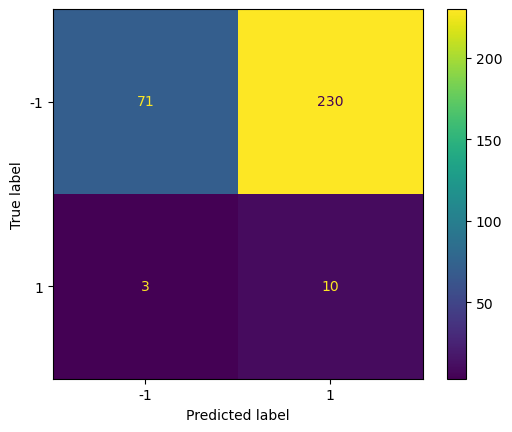

In [18]:
# Split data into train and test set
X_train_droped, X_test_droped, y_train_droped, y_test_droped = train_test_split(X_droped,y,test_size = 0.2, random_state = 0)
# Train the model
gnb.fit(X_train_droped, y_train_droped)
# Predict
y_pred_dropped = gnb.predict(X_test_droped)

ConfusionMatrixDisplay.from_predictions(y_test_droped,y_pred_dropped)

print(classification_report(y_test_droped,y_pred_dropped))


Our new model have a score of 25.79%  accuracy. It have higher accuracy score but still we are getting 230 false negatives. I wanted to try if I can improve the model by selecting features using stepwise selection.

In Gaussian Naive Bayes, the likelihood of the features is assumed to be Gaussian, and the formula for the Gaussian distribution is:

$$
P(x|y) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{ -\frac{(x-\mu)^2}{2\sigma^2} }
$$

where:
- $x$ is a feature vector,
- $y$ is the class,
- $\mu$ is the mean of the feature values for class $y$, and
- $\sigma^2$ is the variance of the feature values for class $y$.


When you perform feature selection, each subset of features is used to train a new Gaussian Naive Bayes model. If any of these subsets include a feature with zero variance ( variance ($\sigma^2$) being in the denominator), it gives the “divide by zero” error. To avoid this, I added a preprocessing step to remove features with zero variance before performing feature selection.

In [19]:
var = X_droped.var()
zero_variance_features = var[var == 0].index.tolist()

print(f"Number of features with zero variance: {len(zero_variance_features)}")

X_droped = X_droped.drop(columns=zero_variance_features)

display(X_droped.head())

Number of features with zero variance: 112


,0,1,2,3,4,7,8,9,10,11,...,572,573,578,579,581,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.239971,0.436850,1.128343,-0.381523,-0.481360,...,-0.226018,-0.120518,-0.662093,-0.650088,-0.530195,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.278951,0.393723,0.022511,-1.608226,-0.011526,...,-0.261137,-0.323417,0.083539,1.318609,2.327864,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,0.232175,-0.192349,0.327111,0.124224,-0.044305,...,-0.199823,-0.633805,3.873831,4.090457,0.607241,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.045074,0.300837,-0.765478,-0.370762,-0.006063,...,-0.221613,-0.691776,0.906840,0.809295,0.483463,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.185400,0.465600,-0.149655,-0.790424,-0.169959,...,-0.227409,-0.496123,-0.662093,-0.650088,-0.530195,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


In [20]:
# Download the required package to the environment

# !pip install mlxtend
# !pip install scikit-learn==1.4.1.post1
# !pip install --upgrade mlxtend


In [21]:
import os
import pickle
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Check if the pickle file exists
if os.path.exists('forward_f1.pkl'):
    # Load the forward object
    with open('forward_f1.pkl', 'rb') as f:
        forward_f1 = pickle.load(f)
else:
    # Forward Selection
    forward_f1 = SFS(gnb,
               k_features=(1,len(X_droped.columns)),
               floating=True,
               scoring="f1",
               cv=0)
    forward_f1 = forward_f1.fit(X_droped.to_numpy(), y)

    # Save the forward object
    with open('forward_f1.pkl', 'wb') as f:
        pickle.dump(forward_f1, f)


print ('Forward Scores \n')
print('Best F1 score: %.2f' % forward_f1.k_score_)
print('Best subset (indices):', forward_f1.k_feature_idx_)
print('Best subset (corresponding names):', forward_f1.k_feature_names_)


Forward Scores 

Best F1 score: 0.43
Best subset (indices): (1, 3, 4, 7, 8, 10, 13, 14, 15, 17, 18, 21, 22, 23, 27, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 49, 50, 51, 52, 55, 57, 60, 61, 62, 63, 66, 67, 69, 70, 71, 73, 74, 75, 76, 80, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 128, 130, 132, 133, 134, 135, 137, 139, 140, 141, 142, 143, 144, 148, 149, 150, 151, 152, 155, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 194, 195, 196, 197, 198, 200, 201, 202, 205, 208, 209, 210, 213, 214, 215)
Best subset (corresponding names): ('1', '3', '4', '7', '8', '10', '13', '14', '15', '17', '18', '21', '22', '23', '27', '30', '31', '32', '33', '34', '35', '37', '38', '39', '40', '41', '42', '45', '46', '49', '50', '51', '52', '55', '57', '60', '61', '62', '63', '66', '67', '69', '70', '71', 

/Users/cemkazan/miniconda3/envs/dat402_project/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianNB from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
# Check if the pickle file exists
if os.path.exists('forward_roc.pkl'):
    # Load the forward object
    with open('forward_roc.pkl', 'rb') as f:
        forward_roc = pickle.load(f)
else:
    # Forward Selection
    forward_roc = SFS(gnb,
               k_features=(1,len(X_droped.columns)),
               floating=True,
               scoring="roc_auc",
               cv=0)
    forward_roc = forward_roc.fit(X_droped.to_numpy(), y)

    # Save the forward object
    with open('forward_roc.pkl', 'wb') as f:
        pickle.dump(forward_roc, f)

# print('best combination (ACC: %.3f): %s\n' % (forward.k_score_, forward.k_feature_idx_))
print ('Forward Scores \n')
print('Best ROC_AUC score: %.2f' % forward_roc.k_score_)
print('Best subset (indices):', forward_roc.k_feature_idx_)
print('Best subset (corresponding names):', forward_roc.k_feature_names_)


Forward Scores 

Best ROC_AUC score: 0.91
Best subset (indices): (1, 6, 7, 8, 10, 11, 15, 22, 23, 26, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 42, 43, 46, 48, 50, 52, 53, 55, 57, 60, 63, 66, 67, 70, 73, 74, 76, 80, 84, 87, 91, 92, 93, 94, 95, 96, 97, 102, 109, 111, 113, 117, 118, 119, 120, 121, 122, 125, 128, 129, 132, 133, 135, 139, 140, 142, 144, 146, 150, 152, 155, 156, 159, 160, 161, 163, 165, 167, 168, 169, 170, 171, 175, 179, 181, 183, 185, 186, 187, 188, 190, 194, 195, 200, 202, 203, 205, 210, 211, 213, 214, 215)
Best subset (corresponding names): ('1', '6', '7', '8', '10', '11', '15', '22', '23', '26', '29', '30', '31', '33', '34', '35', '37', '38', '39', '41', '42', '43', '46', '48', '50', '52', '53', '55', '57', '60', '63', '66', '67', '70', '73', '74', '76', '80', '84', '87', '91', '92', '93', '94', '95', '96', '97', '102', '109', '111', '113', '117', '118', '119', '120', '121', '122', '125', '128', '129', '132', '133', '135', '139', '140', '142', '144', '146', '150', '152', 

pickle package is used to save the object into file so that I could accses the stewise selection results without runing it the second time.

/Users/cemkazan/miniconda3/envs/dat402_project/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cemkazan/miniconda3/envs/dat402_project/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


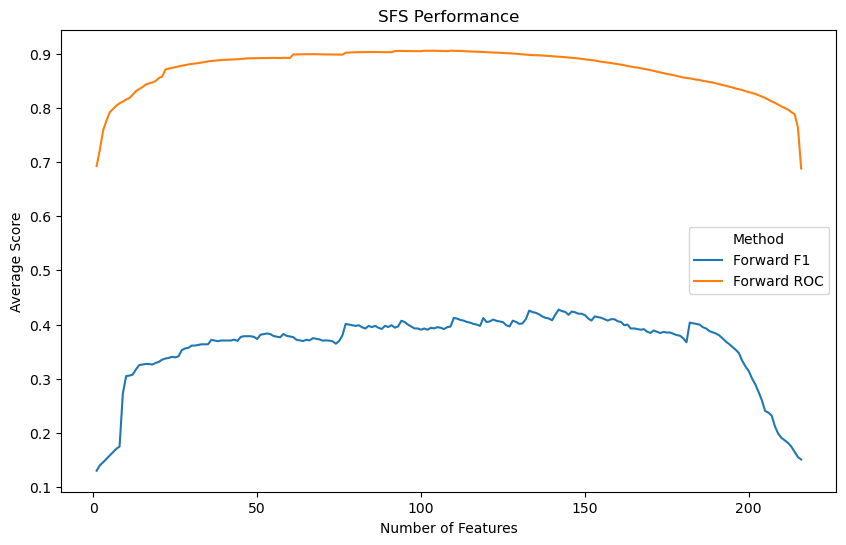

In [23]:
# Get the scores from the Sequential Feature Selector (SFS) for forward selection
scores_forward_f1 = forward_f1.get_metric_dict()
scores_forward_roc = forward_roc.get_metric_dict()

# Initialize empty lists
k_feat_forward = []
avg_scores_forward_f1 = []
avg_scores_forward_roc = []

# Populate the lists using a for loop
for k in scores_forward_f1.keys():
    k_feat_forward.append(k)
    avg_scores_forward_f1.append(scores_forward_f1[k]['avg_score'])
    avg_scores_forward_roc.append(scores_forward_roc[k]['avg_score'])

# Create a DataFrame
df_forward_f1 = pd.DataFrame({'Number of Features': k_feat_forward, 'Average Score': avg_scores_forward_f1, 'Method': 'Forward F1'})
df_forward_roc = pd.DataFrame({'Number of Features': k_feat_forward, 'Average Score': avg_scores_forward_roc, 'Method': 'Forward ROC'})

# Concatenate the two dataframes
df = pd.concat([df_forward_f1, df_forward_roc])

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Number of Features', y='Average Score', hue='Method')
plt.title('SFS Performance')
plt.show()


In [24]:
print('Number of features in the best F1 model:', len(forward_f1.k_feature_idx_))
print('Number of features in the best AUC model:', len(forward_roc.k_feature_idx_))


Number of features in the best F1 model: 142
Number of features in the best AUC model: 102


I used the Sequential Feature Selector (SFS) from the mlxtend library with two scoring metrics: F1 score and AUC.

The graph shows the trade-off between model complexity (number of features) and performance. As more features are added, the model’s performance improves, indicating a reduction in bias. However, beyond a certain point (around the 190-feature mark), adding more features decreases performance. This suggests that the model is overfitting, indicating low bias and high variance. Conversely, reducing the number of features can maintain performance up to a point, but removing too many can lead to underfitting.

The goal of this analysis was to find the optimal number of features that minimizes total error. Based on the results, it seems that around 142 features provide the best balance between bias and variance for this particular dataset and model.

It’s important to note that the model scores are based on training data only. While cross-validation with cv=5 might give better results, it was computationally too heavy for the machine. Therefore, I used cv=0 for this analysis. The exhaustive feature selection took more than 4 days to compute even with cv=0 since there are almost 300 features."

142
              precision    recall  f1-score   support

          -1       0.16      0.94      0.27        50
           1       0.77      0.04      0.07       264

    accuracy                           0.18       314
   macro avg       0.46      0.49      0.17       314
weighted avg       0.67      0.18      0.10       314



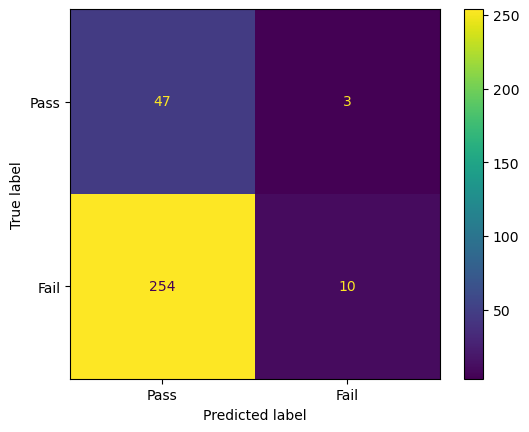

In [25]:
bestcolumns = forward_f1.k_feature_names_
len(bestcolumns)
selectedcolumns = []
for column in bestcolumns:
    if column in X_droped.columns:
        selectedcolumns.append(column)
forward_X = X_droped[selectedcolumns]
print(len(bestcolumns))
# display(forward_X)

# Split data into train and test set
X_train_droped_f1, X_test_droped_f1, y_train_droped_f1, y_test_droped_f1 = train_test_split(forward_X,y,test_size = 0.2, random_state = 0)
# Train the model
gnb.fit(X_train_droped_f1, y_train_droped_f1)
# Predict
y_pred_forward = gnb.predict(X_test_droped_f1)

print(classification_report(y_pred_forward, y_test_droped_f1))
ConfusionMatrixDisplay.from_predictions(y_pred_forward,y_test_droped_f1,display_labels=['Pass', 'Fail'])


The model with removed features observed a decrease in the F1 score. This suggests that the removed features were providing valuable information. In addition since it was computationaly cumbersome the removed features relied on just the training data which is not a good practice in Machine Learning.

Comparing the two models, we can see that both models have issues with precision and recall, indicating a trade-off between bias and variance. The initial model (prior to feature selection) has high precision but low recall for the -1 class, and low precision but high recall for the 1 class. This suggests that this model has biased towards predicting the -1 class and has high variance in predicting the 1 class. After feature selection, the new model shows a significant increase in recall for the -1 class but a drastic drop in precision for the 1 class, indicating an increase in model complexity and a potential overfitting issue. The decrease in accuracy from 0.26 to 0.18 also suggests that the new model may not generalize well to unseen data. Therefore, while feature selection has improved recall for the -1 class, it has negatively impacted the model’s overall performance and generalizability.

Given these observations, I’ve decided to proceed without the feature selection.

 I also wanted to evaluate how KNN performs on our data. I test the KNN to see how non-parametric approach on this semiconductor manufacturing data will perform.

#### KNN

The best k value is: 4
The F1 for best k value is 0.9383356636114132


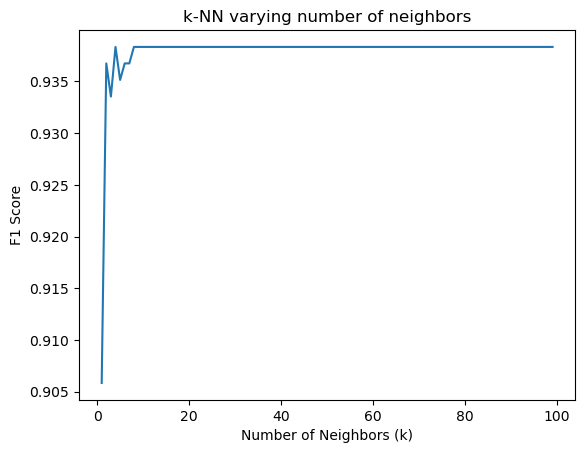

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# List to hold the different accuracy scores
f1 = []

# Range of k values to test
k_values = range(1, 100)

# Iterate over the different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_droped, y_train_droped)
    y_pred_knn = knn.predict(X_test_droped)
    f1.append(f1_score(y_test_droped, y_pred_knn, average='weighted'))

# Find the k value with the highest accuracy
best_k = k_values[np.argmax(f1)]
print(f"The best k value is: {best_k}")
print (f"The F1 for best k value is {f1[(best_k-1)]}")

# Plot the accuracy scores
plt.figure()
sns.lineplot(x=k_values, y=f1)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('k-NN varying number of neighbors')
plt.show()



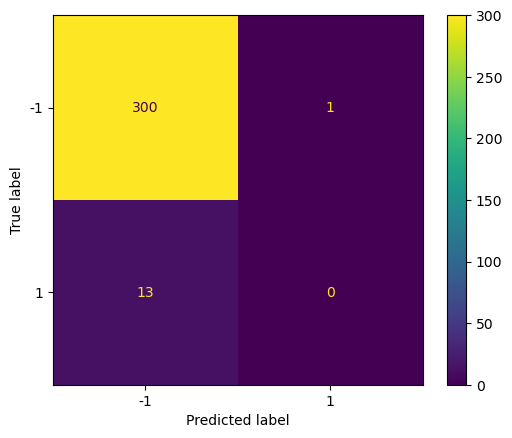

In [27]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_droped, y_train_droped)
y_pred_knn_2 = knn.predict(X_test_droped)
ConfusionMatrixDisplay.from_predictions(y_test_droped,y_pred_knn_2)

KNearest neigbour model prection gives almost 94% accuracy on the test set. This is a large increase compared to our naive bayes model. For the generalizability, our KNN model can suffer as the data points increase and the model behaves poorly becasue the skewness of the target values. To see if the models are generazable I will test the models with cross validation.

#### K-Cross validation on Naive Bayes Calssifier and KNearest neighbour models

##### KNN Cross Validation

In [28]:
from sklearn.model_selection import cross_val_score

# Range of k values to test
k_values = range(1, 100)
folds= [3,5,10]
# List to hold the average cross-validated accuracy for each k
cv_scores = {}

# Iterate over the different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    for fold in folds:
        # Perform n-fold cross validation and compute the mean accuracy
        scores = cross_val_score(knn, forward_X, y, cv= fold, scoring='f1_weighted')
        cv_scores[(k, fold)] = scores.mean()



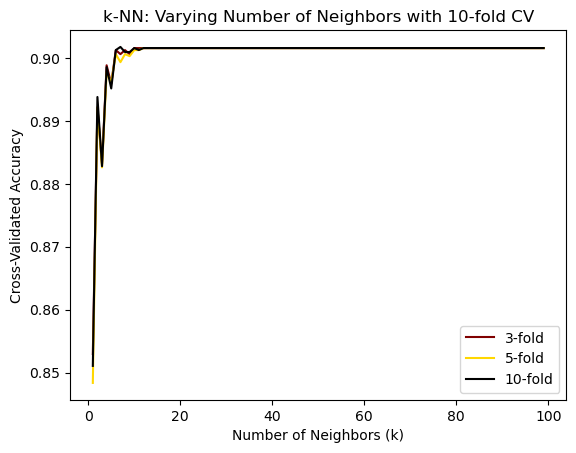

In [29]:
# Plot the cross-validated accuracy scores for each fold
colors = ['maroon', 'gold', 'black']
plt.figure()

for i, fold in enumerate(folds):
    plt.plot(k_values, [cv_scores[(k, fold)] for k in k_values],color=colors[i], label=f'{fold}-fold')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'k-NN: Varying Number of Neighbors with {fold}-fold CV')
plt.legend()
plt.show()

In [30]:
# Initialize maximum score and corresponding k and fold
max_score = float('-inf')
best_k = None
best_fold = None


for (k, fold), score in cv_scores.items():
    if score > max_score:
        max_score = score
        best_k = k
        best_fold = fold

print(f"The best score is {max_score} with k = {best_k} and fold = {best_fold}")

The best score is 0.9017739516404968 with k = 7 and fold = 10


Our model with training test split gave us an accuracy score of 96%. I tested the same range of nearest neigbors with cross validation on 3,5 and 10 folds. for the k value 8 and fold 10 I got the best mean accuracy score that is 93.36%. Eventhough the model accuracy is lower, using the k equals 8 more reliable for generilization of the model.K value like 2 might make the model more sensitive to noise in the data and make model prone to overfitting.

##### Naive Bayes Cross Validation

In [31]:
folds= [3,5,10]

cv_scores_gnb = {}
gnb = GaussianNB()
# Iterate over the different k values

for fold in folds:
    # Perform n-fold cross validation and compute the mean accuracy
    scores = cross_val_score(gnb, forward_X, y, cv= fold, scoring='f1_weighted')
    cv_scores_gnb[fold] = scores.mean()
cv_scores_gnb



{3: 0.3730319375493088, 5: 0.25124987423742906, 10: 0.205070250016679}

In [32]:
max_score_gnb = float('-inf')
best_fold_gnb = None

for fold, score in cv_scores_gnb.items():
    if score > max_score_gnb:
        max_score_gnb = score
        best_fold_gnb = fold

print(f"The best score is {max_score_gnb} fold = {best_fold_gnb}")

The best score is 0.3730319375493088 fold = 3


Comparing the accuracy scores both KNN with k = 8 and naive bayes classifier.

In [33]:
from sklearn.model_selection import cross_val_predict

knn = KNeighborsClassifier(n_neighbors=8)

y_pred_Xknn = cross_val_predict(knn, forward_X, y, cv=10)
y_pred_Xgnb = cross_val_predict(gnb, forward_X, y, cv=3)

print("Classification Report for KNN")
print(classification_report(y, y_pred_Xknn))
print("Classification Report for Naive Bayes")
print(classification_report(y, y_pred_Xgnb))

Classification Report for KNN
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      1463
           1       0.00      0.00      0.00       104

    accuracy                           0.93      1567
   macro avg       0.47      0.50      0.48      1567
weighted avg       0.87      0.93      0.90      1567

Classification Report for Naive Bayes
              precision    recall  f1-score   support

          -1       0.93      0.33      0.49      1463
           1       0.06      0.63      0.11       104

    accuracy                           0.35      1567
   macro avg       0.50      0.48      0.30      1567
weighted avg       0.87      0.35      0.46      1567



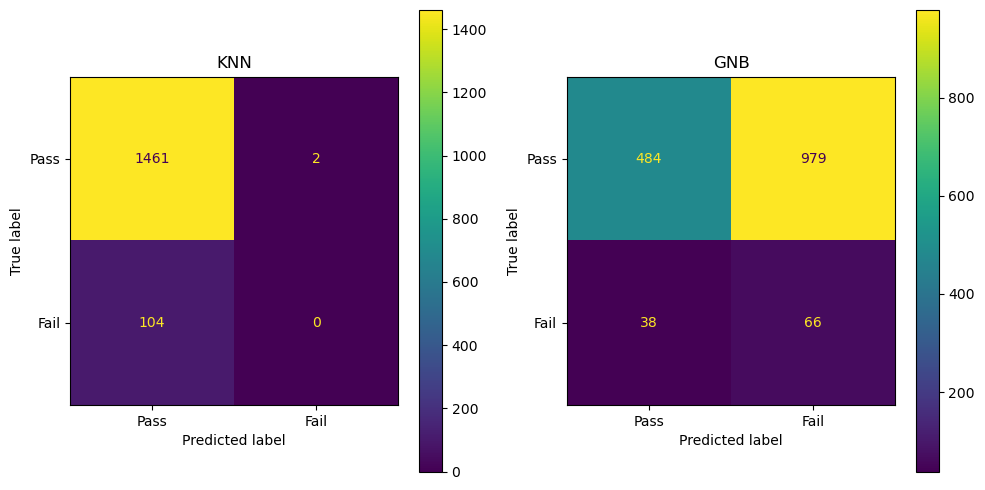

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Compute confusion matrices
cm_Xknn = confusion_matrix(y, y_pred_Xknn,)
cm_Xgnb = confusion_matrix(y, y_pred_Xgnb)

# Create ConfusionMatrixDisplay instances
dsp_Xknn = ConfusionMatrixDisplay(cm_Xknn,display_labels=['Pass', 'Fail'])
dsp_Xgnb = ConfusionMatrixDisplay(cm_Xgnb,display_labels=['Pass', 'Fail'])

# Plot confusion matrices
dsp_Xknn.plot(ax=axes[0])
axes[0].set_title('KNN')

dsp_Xgnb.plot(ax=axes[1])
axes[1].set_title('GNB')

plt.tight_layout()
plt.show()

In this study, two classification algorithms, K-Nearest Neighbors (KNN) and Gaussian Naive Bayes (GNB) were utilized. The prediction results from these models show two distinct patterns:

The KNN algorithm was highly effective at predicting passed class, meaning high bias towards the “pass” class, but it failed to correctly identify any who failed. This suggests that while KNN is good at identifying passing , it may not be the best choice when it’s crucial to also identify those who fail.

On the other hand, the GNB algorithm was more balanced in its predictions. It was able to identify both passing and failing , but it wasn’t perfect at either. This means that while it can identify both passing and failing , it sometimes confuses one for the other. This higher variance suggests that while the model is capturing more complexity in the data, it may also be more sensitive to fluctuations in the data, leading to less consistent performance.

The confusion matrices visually represent these findings. In the KNN matrix, the high count of true negatives (1463) and zero true positives indicate the algorithm’s effectiveness at identifying passing  and its inability to identify failing . In the GNB matrix, the distribution of true and false positives and negatives shows the algorithm’s more balanced, yet imperfect, performance.

This suggests a bias towards class pass in KNN and a more balanced yet less accurate performance overall with GNB.Since there is a huge gap between our target variables, using KNN is not the best choice for generelization. Naive Bayes gives us more balanced results which could be beneficial when applied to future datasets.

In order to enhance the performance of our machine learning models, several strategies can be employed. First, balancing the dataset using techniques such as Synthetic Minority Over-sampling Technique (SMOTE) can help address the issue of class imbalance, potentially improving model performance. Second, feature selection or engineering can be performed with cross validation to identify the most useful features contributing to the prediction variable, thereby reducing the risk of the model learning based on irrelevant features. Lastly, other machine learning model and  methods like Bagging and Boosting can be used to combine decisions from multiple models, resulting in a more robust model that generalizes well to new data.